# **Tarea 5 - Parte 2**

In [ ]:
#Importamos librerías y funciones
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from numba import jit, njit
from IPython.display import Image

# Funciones

**Box Muller**

In [ ]:
#Definimos una función de Box-Muller para generar 1 número aleatorio con distribución gaussiana.
@njit
def boxmull():
    #Generamos 2 números aleatorios de la distribución uniforme en el intervalo (0,1)
    u1 = rd.uniform(0,1)
    u2 = rd.uniform(0,1)
    #Generamos el nuevo número aleatorio con la condición de Box-Muller
    sample = np.sqrt(-2.*np.log(u1))*np.cos(2.*np.pi*u2)
    return sample

**Configuración inicial**

In [ ]:
#Definimos la función para generar el estado inicial de la muestra aleatoria
@njit
def config(seed, nr, N):
    i = 0
    rd.seed(seed)
    #Set de coordenadas para calcular propiedades estructurales
    muestraX = np.zeros(N)
    muestraY = np.zeros(N)
    muestraZ = np.zeros(N)
    rad = 0.5
    L = ((N/nr)**(1./3.))/2 #Calculamos la longitud de la celda de tal modo que quede centrada
    #Generamos las primeras coordenadas
    x_n = rd.uniform(-L+0.5, L-0.5)
    y_n = rd.uniform(-L+0.5, L-0.5)
    z_n = rd.uniform(-L+0.5, L-0.5)
    #La primer coordenada simplemente la agregamos a la lista
    muestraX[0] = x_n
    muestraY[0] = y_n
    muestraZ[0] = z_n
    i=1
    while i < N:
        err = False
        x_n = rd.uniform(-L+0.5, L-0.5)
        y_n = rd.uniform(-L+0.5, L-0.5)
        z_n = rd.uniform(-L+0.5, L-0.5)
        muestraX[i] = x_n
        muestraY[i] = y_n
        muestraZ[i] = z_n
        for j in range(i):
            dist = np.sqrt((x_n - muestraX[j])**2 + (y_n - muestraY[j])**2 + (z_n - muestraZ[j])**2)
            if dist<2*rad: #Si la distancia es menor a dos veces el radio paramos la iteración e indicamos que hay un error con el valor generado 
                seed=seed + 0.1
                rd.seed(seed)
                err = True
                break
            else:
                continue
        if err == False: #Si no hay un error registrado entonces agregamos la coordenada generada a la lista
            muestraX[i] = x_n
            muestraY[i] = y_n
            muestraZ[i] = z_n
            i = i + 1
    v = np.column_stack((muestraX, muestraY, muestraZ))    
    return v

**Subrutina de fuerzas (Yukawa)**

In [ ]:
@njit
def FYukawa(x, y, z, N, L, radC):
    E = 0
    #Creamos arreglos para las fuerzas en cada dirección
    fx = np.zeros(N)
    fy = np.zeros(N)
    fz = np.zeros(N)  
    for i in range(N-1):
        fxi = fx[i]
        fyi = fy[i]
        fzi = fz[i]   
        for j in range(i+1, N):
            xij = x[i] - x[j]
            yij = y[i] - y[j]
            zij = z[i] - z[j]
            #Convención de imagen mínima
            xij = xij - L*round(xij/L)
            yij = yij - L*round(yij/L)
            zij = zij - L*round(zij/L)
            rij = (xij**2 + yij**2 + zij**2)**0.5

            if rij < rCut and rij>1 :
                #Utilizando Yukawa
                A = 556
                zk = 0.149
                K = A*np.exp(zk)
                EPot = K*np.exp(-zk*rij)/rij
                E = EPot + E
                U2 = EPot*(zk*rij+1.)/rij**2
                #Fuerza sobre cada partícula conociendo el potencial de interacción
                fxij = xij*U2
                fyij = yij*U2
                fzij = zij*U2
                fxi = fxi + fxij
                fyi = fyi + fyij
                fzi = fzi + fzij
                fx[j] = fx[j] - fxij
                fy[j] = fy[j] - fyij
                fz[j] = fz[j] - fzij       
        fx[i] = fxi
        fy[i] = fyi
        fz[i] = fzi  
    return E, fx, fy, fz

**Movimiento Browniano (Yukawa)**

In [ ]:
@njit
def BrownianYukawa(x, y, z, fx, fy, fz, L, N, radC, nStep, dT, Nener, nFrec1, nFrec2):
    ki1 = 0 #Contador (estructurales)
    ki2 = 0 #Contador (dinámicas)
    Var = np.sqrt(2.0*dT) #Varianza
    V = np.zeros(nStep) #Arreglo de potencial de configuración
    #Matrices de coordenadas para propiedades estructurales (renglones: partículas, columnas: configuración)
    Mx = np.zeros((N,nStep))
    My = np.zeros((N,nStep))
    Mz = np.zeros((N,nStep))
    #Matrices de coordenadas para propiedades dinámicas (renglones: partículas, columnas: configuración)
    Mxr = np.zeros((N,nStep))
    Myr = np.zeros((N,nStep))
    Mzr = np.zeros((N,nStep))
    #Copiamos arreglos de coordenadas para tener el set para calcular propiedades dinámicas
    xr = x #np.zeros(N)
    yr = y #np.zeros(N)
    zr = z #np.zeros(N)
    
    for i in range(nStep):
        for j in range(N):
            #Generando números aleatorios
            ax = float(boxmull())
            ay = float(boxmull())
            az = float(boxmull())
            #Coords para propiedades estructurales
            x[j] = x[j] + fx[j]*dT + Var*ax
            y[j] = y[j] + fy[j]*dT + Var*ay
            z[j] = z[j] + fz[j]*dT + Var*az
            #Aplicando condiciones periódicas
            x[j] = x[j] - L*round(x[j]/L)
            y[j] = y[j] - L*round(y[j]/L)
            z[j] = z[j] - L*round(z[j]/L)
            #Coords para propiedades dinámicas
            xr[j] = xr[j] + fx[j]*dT + Var*ax
            yr[j] = yr[j] + fy[j]*dT + Var*ay
            zr[j] = zr[j] + fz[j]*dT + Var*az
            
            #Guardamos valores de coordenadas en las matrices para la configuración a partir de la configuración de termalización
            #Además consideramos la frecuencia con la que se guardan los datos utilizando nFrec1 para propiedades estructurales
            if i>nener and i%nFrec1==0.0 : 
                Mx[j][ki1] = x[j]
                My[j][ki1] = y[j]
                Mz[j][ki1] = z[j]
                
            #Guardamos valores de coordenadas en las matrices para la configuración a partir de la configuración de termalización
            #Además consideramos la frecuencia con la que se guardan los datos utilizando nFrec2 para propiedades dinámicas
            if i>nener and i%nFrec2==0.0 : 
            #for i in range(N):
                Mxr[j][ki2] = xr[j]
                Myr[j][ki2] = yr[j]
                Mzr[j][ki2] = zr[j]
        #Aumento en las variables de iteración    
        if i>nener and i%iFrec1==0.0 :
            ki1 = ki1 + 1
        if i>nener and i%iFrec2==0.0 : 
            ki2 = ki2 + 1
        #Calculamos la energía y las fuerzas de la nueva configuración. 
        #Primero borramos la memoria de los arreglos de fuerzas    
        fx = np.zeros(N)
        fy = np.zeros(N)
        fz = np.zeros(N)
        E, fx, fy, fz = FYukawa(x, y, z, N, L, radC)
                
        V[i] = E
    
    return x, y, z, Mx, My, Mz, Mxr, Myr, Mzr, V, ki1, ki2

**Función de distribución radial**

In [ ]:
@njit
def gdr(Mx, My, Mz, radC, L, nStep, nr, N, ki2):
    #Definimos valores a utilizar
    nhist = np.zeros(int(nStep))
    deltar = 0.05
    maxbin = int(L/2/deltar)
    
    for i in range(N):
        for j in range(N):
            if i != j :
                for k in range(ki2):
                    xL0 = Mx[i,k]
                    xLT = Mx[j,k]
                    xL0T = xL0-xLT
                    yL0 = My[i,k]
                    yLT = My[j,k]
                    yL0T = yL0-yLT
                    zL0 = Mz[i,k]
                    zLT = Mz[j,k]
                    zL0T = zL0-zLT                  
                    xL0T = xL0T-L*round(xL0T/L)
                    yL0T = yL0T-L*round(yL0T/L)
                    zL0T = zL0T-L*round(zL0T/L)                    
                    R0T = np.sqrt(xL0T**2 + yL0T**2 + zL0T**2)                   
                    nBin = int(R0T/deltar)+1
                    
                    if nBin <= maxbin :
                        nhist[nBin] = nhist[nBin] + 1
    
    c1 = 4.0*(np.pi)*nr/3.0  
    gdrTA = np.zeros(maxbin)
    rt = np.zeros(maxbin)
    for i in range(maxbin):
        rl = float(i)*deltar
        ru = rl + deltar
        rt[i] = rl + deltar/2.0
        c2 = c1*(ru**3 - rl**3)
        gdrTA[i] = float(nhist[i])/float(ki2)/float(N)/c2
        
    return rt, gdrTA

**Cálculo de presión del sistema**

In [ ]:
@njit
def PHS(rt, gdr, nr):
    #xig = np.zeros(len(rt))
    #xig = 0.0
    #isig = np.zeros(len(rt))
    for i in range(len(rt)):
        if rt[i] > (1.0-0.01) and rt[i] > (1.0 + 0.01):
            xog = gdr[i]
            isig = i
    
    print("ICONTACTO = ", isig, ", GDR DE CONTACTO = ", xog)
    
    #expresion exacta para la presion de un sistema de hs
    phs = nr + 2.0 * np.pi * nr * xog / 3.0
    
    print("rho = ", nr, ", Phs = ", phs)

**Desplazamiento cuadrático medio**

In [ ]:
@njit
def wdt(Mxr, Myr, Mzr, N, ki2, dT, nFrec2):
    tim = float(nFrec2)*dT
    wt = np.zeros(ki2-1)
    time = np.zeros(ki2-1)
    Dif = np.zeros(ki2-1)
    
    for i in range(ki2-1):
        ntmax = ki2 - i
        wtx = 0.0
        wty = 0.0
        wtz = 0.0
        
        for j in range(N):
            for h in range(ntmax):
                wtx = wtx + ( Cxr[j][h+i] - Cxr[j][h] )**2
                wty = wty + ( Cyr[j][h+i] - Cyr[j][h] )**2
                wtz = wtz + ( Czr[j][h+i] - Czr[j][h] )**2
                
        time[i] = tim*float(i+1)
        wt[i] = (wtx + wty + wtz)/float(N)/float(ntmax)/6.0
        dif[i] = wt[i]/time[i]
    
    return time, wt, dif

**II. Elaborar el código de simulación de Dinámica Browniana utilizando un modelo de potencial par de Yukawa**:
<center>$\beta u(r)=K\frac{e^{-\kappa r}}{r}$</center>

**Tomando $K=Ae^{zk}$ con $A=556$ y $zk=0.149$. Calcular la función de distribución radial y el desplazamiento cuadrático medio.**

**Actividades:**

**a) Configuración inicial y final**

In [ ]:
#Definimos los valores que utilizaremos
nStep = 30000 #Número de estados del sistema que se quieren simular
nFrec1 = 1 #Frecuencia con la que se guardan los datos
nFrec2 = 1
Nener = int(nStep/2) #Iteración donde se alcanza equilibrio termodinámico
dT = 0.0004 #Intervalo de tiempo adimensional
Var = np.sqrt(2*dT) #Varianza del sistema
nrYuk = 6*4.4e-4 / np.pi #Concentración reducida para Yukawa
seed = 643 #Semilla para números aleatorios

In [ ]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
nr = nrYuk
print('Concentración reducida:', nr, '\n', end = '')
#Calculamos la longitud de celda y la imprimimos
L = ((N/nr)**(1./3.))
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:1000
Concentración reducida: 0.0008403380995252073 
Longitud de celda: 105.96976761140812 
Radio de corte: 52.98488380570406 


In [ ]:
#Generamos la muestra aleatoria en su estado inicial, hacemos arreglos con las listas y hacemos un dataframe
coords = config(seed, nr, N)
muestraX = coords[:,0]
muestraY = coords[:,1]
muestraZ = coords[:,2]
muestra0 = {'x_0': muestraX, 'y_0': muestraY, 'z_0': muestraZ} 
df0 = pd.DataFrame(muestra0)

In [ ]:
#Calculamos las fuerzas y la energía de la configuración inicial
V0, fx, fy, fz = FYukawa(muestraX, muestraY, muestraZ, N, L, radC)
print('Energía de configuración inicial:', V0)

Energía de configuración inicial: 150623.33299416205


In [ ]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, muestraFz, Mx, My, Mz, Mxr, Myr, Mzr, V, ki1, ki2 = BrownianYukawa(muestraX, muestraY, muestraZ, fx, fy, fz, L, N, radC, nStep, dT, Nener, nFrec1, nFrec2)
muestraF = {'x_f': muestraFx, 'y_f': muestraFy, 'z_f': muestraFz} #Creamos lista de listas para las posiciones finales
df1 = pd.DataFrame(muestraF)

Text(0.5, 0, 'z')

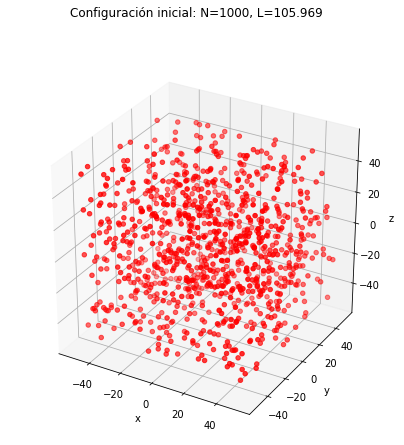

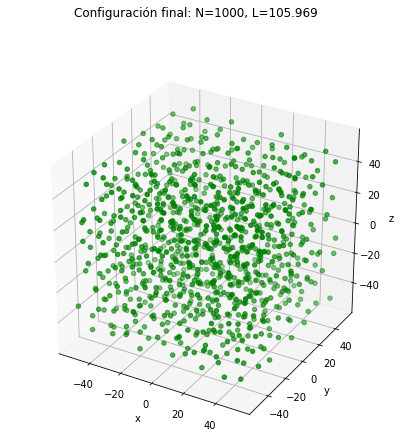

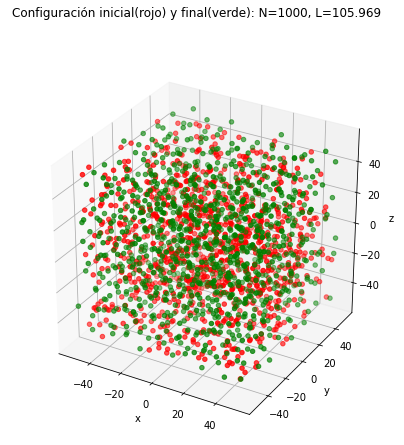

In [ ]:
#Graficamos la configuración inicial
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración inicial: N=1000, L=105.969')
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(df0['x_0'], df0['y_0'], df0['z_0'], c = 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

#Graficamos la configuración final
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración final: N=1000, L=105.969')
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df1['x_f'], df1['y_f'], df1['z_f'], c = 'g')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

#Graficamos la configuración inicial y final
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración inicial(rojo) y final(verde): N=1000, L=105.969')
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df0['x_0'], df0['y_0'], df0['z_0'], c = 'r')
ax3.scatter(df1['x_f'], df1['y_f'], df1['z_f'], c = 'g')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

**b) Curva de termalización (energía potencial por partícula)**

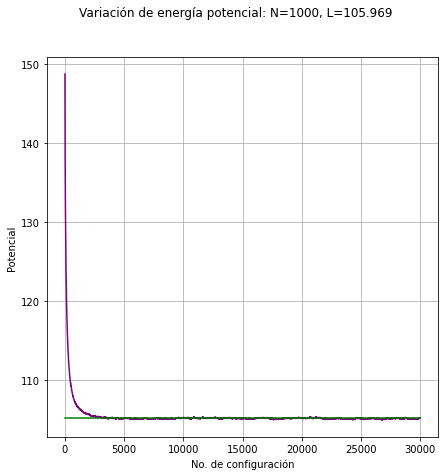

In [ ]:
#Calculamos potencial promedio para graficarlo también
VProm = V[Nener:].mean()
VPromN = VProm/N

#Graficamos la variación de energía potencial total a través de la variación de configuraciones
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Variación de energía potencial: N=1000, L=105.969')
ax4 = fig.add_subplot()
ax4.plot(np.linspace(0,nStep, nStep), V/N, c = 'purple')
ax4.plot([0, nStep], [VPromN,VPromN], c = 'green')
#ax4.set_ylim([1e8, 2e8])
ax4.set_xlabel('No. de configuración')
ax4.set_ylabel('Potencial')

plt.grid()

**c) Función de distribución radial**

In [ ]:
#Calculamos la distribución radial
rt, gdr = gdr(Mx, My, Mz, radC, L, nStep, nr, N, ki2)

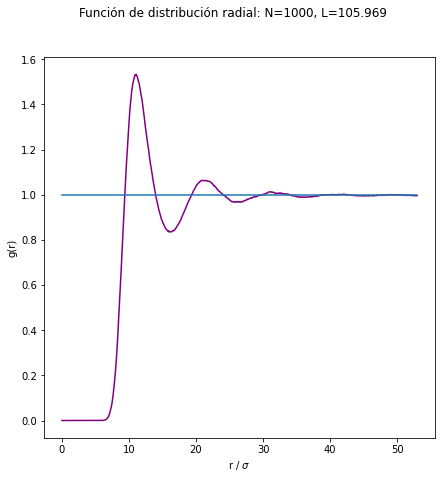

In [ ]:
#Graficamos la función de distribución radial
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,7)
fig.suptitle('Función de distribución radial: N=1000, L=105.969')
ax.plot(rt, gdr, c='purple')
ax.plot([rt.min(), rt.max()],[1,1])

ax.set_ylabel("g(r)")
ax.set_xlabel("r / $\sigma$")

plt.show()

**d) Desplazamiento cuadrático medio**

In [ ]:
#Utilizamos la funcion de desplazamiento cuadrático medio
time, wt, Dif = wdt3(Mxr, Myr, Mzr, N, ki2, dT, nFrec2)

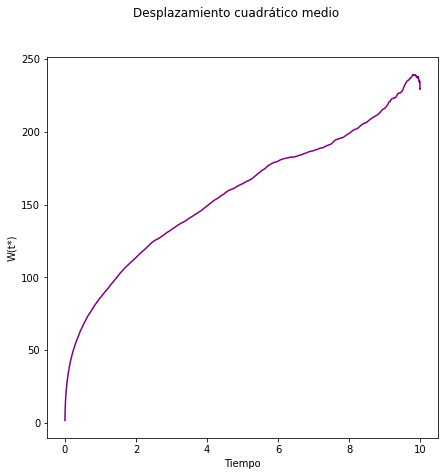

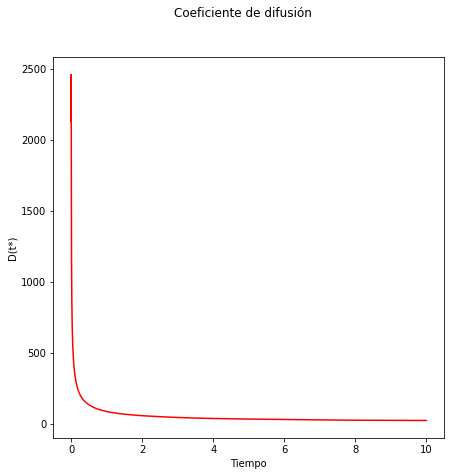

In [ ]:
#Graficamos el desplazamiento cuadrático medio
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,7)
fig.suptitle('Desplazamiento cuadrático medio')
ax.plot(time[1:], wt[1:], c='purple')

ax.set_ylabel("W(t*)")
ax.set_xlabel("Tiempo")

plt.show()

#Graficamos el coeficiente de difusión
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,7)
fig.suptitle('Coeficiente de difusión')
ax.plot(time[1:], Dif[1:], c='red')

ax.set_ylabel("D(t*)")
ax.set_xlabel("Tiempo")

plt.show()

**e) Valor promedio de la energía potencial del sistema**

In [ ]:
#Calculamos el promedio de la energía potencial del sistema
VProm = V[Nener:].mean()
print("El promedio de la energía potencial es ", VProm)
VPromN = VProm/N
print("El promedio de la energía potencial por partícula es ", VPromN)

El promedio de la energía potencial es  105105.09389052555
El promedio de la energía potencial por partícula es  105.10509389052555


**f) Valor promedio de la presión del sistema**

In [ ]:
#Calculamos la presión del sistema
phs = PHS(rt, gdr, nr)

ICONTACTO =  1058 , GDR DE CONTACTO =  0.996192299620559
rho =  0.0008403380995252073 , Phs =  0.0025936365468573913
